# Get Environment Information

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple,List
import matplotlib.ticker as ticker
import numpy as np
np.set_printoptions(linewidth=500)
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_colwidth', 500)

In [49]:
import os
from dotenv import load_dotenv, find_dotenv;
de_path = find_dotenv(filename='data.env', raise_error_if_not_found=True)
load_dotenv(de_path, override=True)

mal_data_folder = os.getenv('MAL_DATA_FOLDER','')
print(mal_data_folder)

data_ranking_info = os.getenv('MAL_RANKING_LIST','')
print(data_ranking_info)

data_user_info = os.getenv('MAL_USER_LIST','')
print(data_user_info)

data_anime_info:str = os.getenv('MAL_ANIME_LIST','')
print(data_anime_info)

/home/sooth/Documents/Beta/80-89 Second Degree/81 Courses/01 CAP5771 - DM TM/04  DM Project/01_Dataset
/home/sooth/Documents/Beta/80-89 Second Degree/81 Courses/01 CAP5771 - DM TM/04  DM Project/01_Dataset/06 UserAnimeList.csv
/home/sooth/Documents/Beta/80-89 Second Degree/81 Courses/01 CAP5771 - DM TM/04  DM Project/01_Dataset/07 UserList.csv
/home/sooth/Documents/Beta/80-89 Second Degree/81 Courses/01 CAP5771 - DM TM/04  DM Project/01_Dataset/03 AnimeList.csv


In [50]:
# x = 'anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,airing,aired_string,aired,duration,rating,score,scored_by,rank,popularity,members,favorites,background,premiered,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme'
# y = x.split(',')
# print('= [')
# for z in y:
# 	print('\'{}\','.format(z))
# print(']')

# may be relevant later
	# 'rating',
	# 'licensor',
	# 'studio',
	# 'producer',

# duplicate information
	# 'title_english', 
	# 'title_japanese',
	# 'title_synonyms',
	# 'airing',
	# 'aired',

# irrelevant information
	# 'image_url',
	# 'source',
	# 'aired_string',
	# 'duration',
	# 'background',
	# 'premiered',
	# 'broadcast',
	# 'related',
	# 'opening_theme',
	# 'ending_theme',

In [51]:
ROWS_TO_READ:int|None = 1000
ANIME_USE_COLUMNS:List[str] = [ # The columns used when reading the file.
	'anime_id',	# PK
	# 'title',	# Used when deciphering results later
	# 'episodes',	# Used in calculating some values in the ranking list
	'status', 	# Only used in filtering
	
	'type',		# Filtering + analysis
	'genre',	# Used in clustering later. Prime descriptor of content

 	'score', 	# !!!! Predictor
	'scored_by',
	
	'rank',
	'popularity',
	
	'members',
	'favorites',
]

# Data Handling Functions

In [52]:
def read_anime_dataset(nrows:int|None = None, use_cols:List[str]|None = ANIME_USE_COLUMNS)->pd.DataFrame:
	""" Load the AnimeList.csv dataset into a dataframe """
	print('nrows=','all' if nrows is None else nrows)
	frame = pd.read_csv(
		filepath_or_buffer=data_anime_info,
		nrows=nrows,
		usecols=use_cols
	)
	return frame

In [53]:
def filter_dataset(anime_list:pd.DataFrame)->Tuple[pd.DataFrame,pd.DataFrame]:
	frame = anime_list.copy()
	""" Apply filtering rules to the AnimeList dataset. Returns the filtered frame & another frame with just the removed records. """
	# Records
	removed_records = frame.loc[ # for analysis
		(frame['status'] != 'Finished Airing')
		| ((frame['type']=='Music') | (frame['type']=='Unknown'))
	].copy()

	frame.drop( # Remove all results which have not finished airing
		index=frame[frame['status']!='Finished Airing'].index,
		inplace=True
	)
	frame.drop( # Drop all results which are of type 'Music' or 'Unknown'.
		index=frame[(frame['type']=='Music')|(frame['type']=='Unknown')].index,
		inplace=True
	)
	return frame, removed_records

In [54]:
def clean_dataset(anime_list:pd.DataFrame)->Tuple[pd.DataFrame,pd.DataFrame]:
	""" Apply cleaning rules to the AnimeList dataset. Return the clean set & the records that were removed. """
	frame = anime_list.copy()
	impossible_score:pd.Series[bool] = (frame['score']<1)|(frame['score']>10)|(frame['score'].isnull())
	no_members:pd.Series[bool] = (frame['members']==0)|(frame['members'].isnull())
	invalid_status:pd.Series[bool] = (frame['status'].isnull())
	no_genre:pd.Series[bool] = (frame['genre'].isnull())
	REMOVE = (impossible_score | no_members | invalid_status | no_genre)
	removed = frame.loc[REMOVE].copy()
	frame.drop(index=REMOVE.index,inplace=True)
	return anime_list, removed

# Plotting Functions

In [55]:
def barchart_by_type(frame:pd.DataFrame)->Tuple[plt.Figure, plt.Axes]:
	""" Plots the amount of entries by the categorical feature 'type'. Returns figure, axes """
	type_counts = frame['type'].value_counts()
	figure,axes = plt.subplots()
	type_counts.plot.bar(ax=axes)
	axes.set_xlabel('Content Types')
	axes.set_ylabel('Count')
	axes.set_title('Entries by Content Type')
	return figure,axes

In [56]:
def boxplot_by_type(frame:pd.DataFrame,
		column:str, exclude_types:List[str]=[], sub_by:str|None = None,
		plot_overall:bool=False, plot_aggregate:bool=False, plot_all_except_include:bool=False,
		show_fliers:bool=True, show_mean:bool=True,
		figure_dpi:int = 100,
		**matplot_kwargs
	)->Tuple[plt.Figure,plt.Axes]:
	""" Plots the column by type. plot_overall shows the entire dataframes boxplot. plot_aggregate respects exclude_types """
	if not (column in frame.columns):
		raise KeyError('boxplot_by_type {} not found in frame.columns'.format(column))
	
	figure,axes = plt.subplots(dpi=figure_dpi)
	# Set the default figure size to 20in by 20in...
	# Set default width to 0.5 * width of graph (must be set to get them to auto adjust when plotting overall/aggregate)
	matplot_kwargs.setdefault('figsize',(20,20))
	matplot_kwargs.setdefault('widths',0.5)

	FILTERED_FRAME = (frame[~frame['type'].isin(exclude_types)] if (len(exclude_types) != 0) else frame)
	FILTERED_FRAME.boxplot(
			column=[column],ax=axes,
			by='type' if sub_by is None  else ['type', sub_by],
			showfliers=show_fliers,
			showmeans=show_mean, meanline=show_mean,
			**matplot_kwargs
		)

	labels = [label.get_text() for label in axes.get_xticklabels()]
	def additional_plot(df:pd.DataFrame, label:str):
		df.boxplot(
			column=[column], ax=axes, by = (sub_by if sub_by is not None else None),
			showfliers=show_fliers,
			showmeans=show_mean, meanline=show_mean,
			positions=[len(labels)+1],
			**matplot_kwargs
		)
		labels.append(label)
		axes.set_xticklabels(labels)
	

	if plot_overall: # Insert the overall boxplot & correct xticklabels
		additional_plot(frame,'All')
	
	if plot_aggregate: # Insert the aggregate (of displayed data), correct xticklabels
		additional_plot(FILTERED_FRAME, 'Aggregate')
	
	if plot_all_except_include and len(exclude_types) != 0:
		additional_plot(frame[frame['type'].isin(exclude_types)],'Excluded')

	axes.set_xlabel('Content Types')
	axes.set_ylabel(column)
	title:str = '{} by Content Type'.format(
		column
	)
	sub_title:str = '({} {})'.format(
		'Show Fliers' if show_fliers else 'Hide Fliers',
		', Show Mean' if show_mean else ''
	)
	figure.suptitle(title)
	axes.set_title(sub_title)
	return figure,axes

In [57]:
def comparison_barchart_by_type(filtered_frame:pd.DataFrame, removed_frame:pd.DataFrame)->Tuple[plt.Figure, plt.Axes]:
	""" Stacked barchart showing removed vs remaining records """
	leftover = filtered_frame['type'].value_counts()
	leftover.name='Leftover'

	removed = removed_frame['type'].value_counts()
	removed.name='Removed'

	figure,axes = plt.subplots()
	tdf = pd.concat([leftover,removed],axis=1)
	tdf.plot(ax=axes, kind='bar',stacked=True)
	return figure,axes

# Data Summary (visualize)
- Fig 01 - Barchart of types

- Fig 02 - Boxplot of score by type & overall (no-fliers)
- Fig 03 (REMOVED)

- Fig 04 - Boxplot of members by type with fliers (< || >1.5 IQR)
- Fig 05 - Boxplot of members by type without fliers
------ Implement?
- Boxplot of favorite by type & overall
- Scatterplot of score by members overall & by type?
- Scatterplot of favorites by members overall & by type?

In [58]:
anime_raw = read_anime_dataset(ROWS_TO_READ)
print(anime_raw.info())
print(anime_raw.describe())

nrows= 1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   anime_id    1000 non-null   int64  
 1   type        1000 non-null   object 
 2   status      1000 non-null   object 
 3   score       1000 non-null   float64
 4   scored_by   1000 non-null   int64  
 5   rank        902 non-null    float64
 6   popularity  1000 non-null   int64  
 7   members     1000 non-null   int64  
 8   favorites   1000 non-null   int64  
 9   genre       997 non-null    object 
dtypes: float64(2), int64(5), object(3)
memory usage: 78.3+ KB
None
           anime_id        score      scored_by         rank    popularity        members     favorites
count   1000.000000  1000.000000    1000.000000    902.00000   1000.000000    1000.000000   1000.000000
mean   15624.782000     6.354450   18886.340000   5725.20510   6489.789000   37133.407000    704.042000
std    127

/tmp/ipykernel_92088/1223149124.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  Figure01.show() # Figure01.savefig('folder........./filename....')


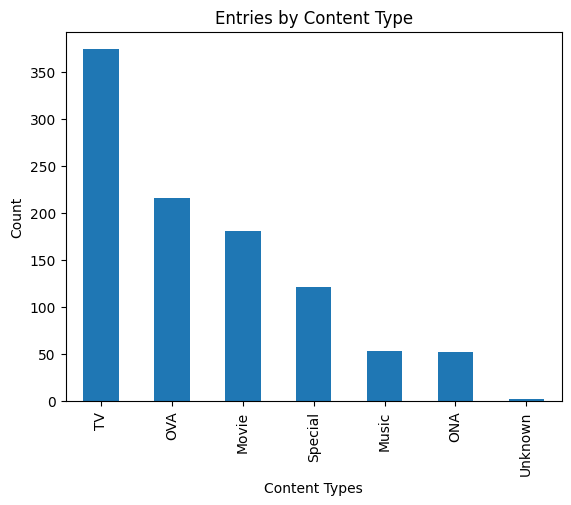

In [59]:
Figure01,f1_ax = barchart_by_type(anime_raw)
Figure01.show() # Figure01.savefig('folder........./filename....')

/tmp/ipykernel_92088/301405226.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  F02A_fig.show()


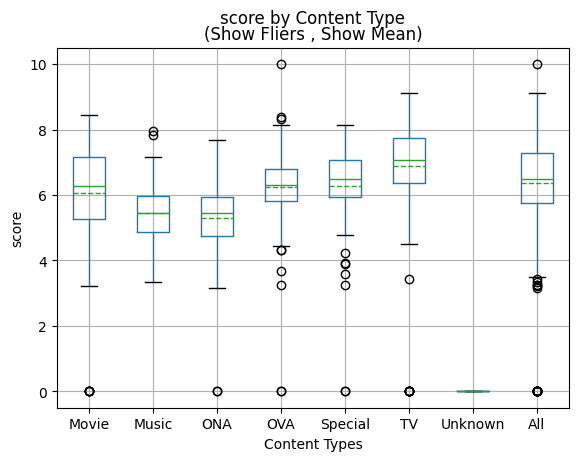

In [60]:
# Figure 2 includes the boxplots of Score by Type with far outliers
F02A_fig,F02A_ax = boxplot_by_type(
	frame=anime_raw,
	column='score',
	plot_overall=True,
	show_fliers=True,
)
F02A_fig.show()

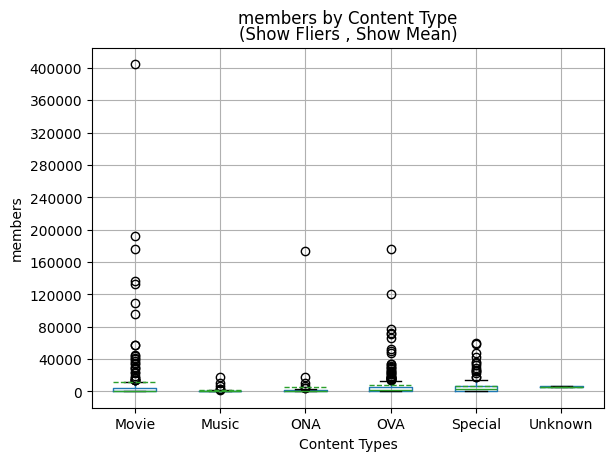

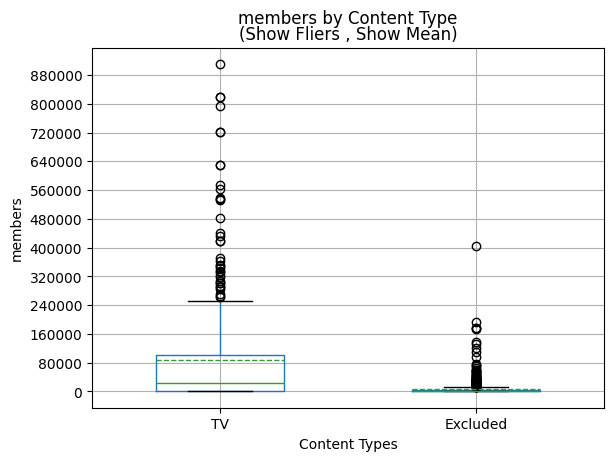

In [61]:
# Figure 4 includes the boxplots of Member by Type with far outliers
F04A_fig,F04A_ax = boxplot_by_type(
	frame=anime_raw,
	column='members',
	exclude_types=['TV'],
	show_fliers=True,
)
F04A_ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=16,steps=[2,4,6,8,10]))

F04B_fig,F04B_ax = boxplot_by_type(
	frame=anime_raw,
	column='members',
	exclude_types=['Movie','Music','OVA','ONA','Special','Unknown'],
	plot_all_except_include=True,
	show_fliers=True,
)
F04B_ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=16,steps=[2,4,6,8,10]))
plt.show()

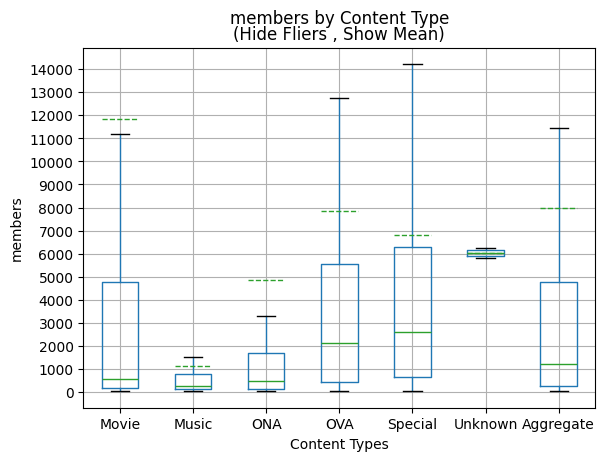

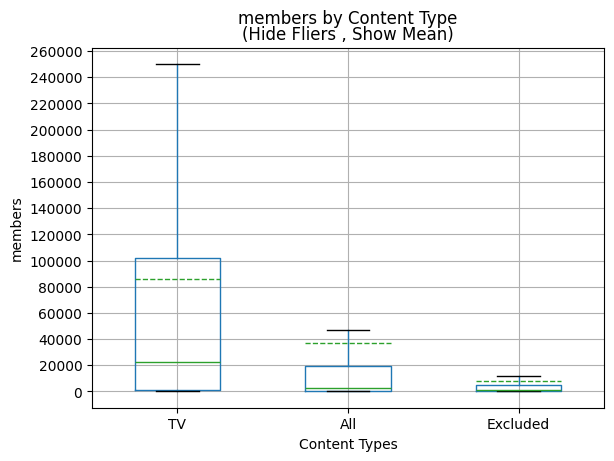

In [62]:
# Figure 5 includes the boxplots of Member by Type without far outliers
F05A_fig,F05A_ax = boxplot_by_type(
	frame=anime_raw, column='members',
	exclude_types=['TV'],
	show_fliers=False,
	plot_aggregate=True
)
F05A_ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=16,steps=[2,4,6,8,10]))

F05B_fig,F05B_ax = boxplot_by_type(
	frame=anime_raw,
	column='members',
	exclude_types=['Movie','Music','OVA','ONA','Special','Unknown'],
	plot_overall=True,
	plot_all_except_include=True,
	show_fliers=False,
)
F05B_ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=16,steps=[2,4,6,8,10]))
plt.show()

# Data Filtering

In [63]:
anime_filtered, filtered_out = filter_dataset(anime_raw)
# Comparison Frame
anime_raw['DATASET_DESCRIPTOR']='Original'
anime_filtered['DATASET_DESCRIPTOR']='Filtered'
clean_comparison_frame = pd.concat([
	anime_raw.drop( # Cannot compare types which no longer exist.
		index=anime_raw[(anime_raw['type']=='Music')|(anime_raw['type']=='Unknown')].index
	),
	anime_filtered
],axis=0)

In [64]:
print('Filtered Info:')
print(anime_filtered.info())
print('describe:')
print(anime_filtered.describe())

Filtered Info:
<class 'pandas.core.frame.DataFrame'>
Index: 906 entries, 0 to 999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   anime_id            906 non-null    int64  
 1   type                906 non-null    object 
 2   status              906 non-null    object 
 3   score               906 non-null    float64
 4   scored_by           906 non-null    int64  
 5   rank                830 non-null    float64
 6   popularity          906 non-null    int64  
 7   members             906 non-null    int64  
 8   favorites           906 non-null    int64  
 9   genre               903 non-null    object 
 10  DATASET_DESCRIPTOR  906 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 84.9+ KB
None
describe:
           anime_id       score      scored_by          rank    popularity        members     favorites
count    906.000000  906.000000     906.000000    830.000000    90

In [65]:
print('Removed Info:')
print(filtered_out.info())
print('describe:')
print(filtered_out.describe())

Removed Info:
<class 'pandas.core.frame.DataFrame'>
Index: 94 entries, 31 to 990
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   anime_id    94 non-null     int64  
 1   type        94 non-null     object 
 2   status      94 non-null     object 
 3   score       94 non-null     float64
 4   scored_by   94 non-null     int64  
 5   rank        72 non-null     float64
 6   popularity  94 non-null     int64  
 7   members     94 non-null     int64  
 8   favorites   94 non-null     int64  
 9   genre       94 non-null     object 
dtypes: float64(2), int64(5), object(3)
memory usage: 8.1+ KB
None
describe:
           anime_id      score      scored_by          rank    popularity        members     favorites
count     94.000000  94.000000      94.000000     72.000000     94.000000      94.000000     94.000000
mean   28983.244681   4.451596    5501.425532   7731.930556   8611.521277   13212.904255    766.223404
std    1

# Data Filtering Results (visualize)
- 1. Barchart of Types
- 2. Score by Type
- 3. Members by Type (Excluding TV)
- 4. Members by Type (Just TV)

Text(0.5, 0.98, 'Filter Results')

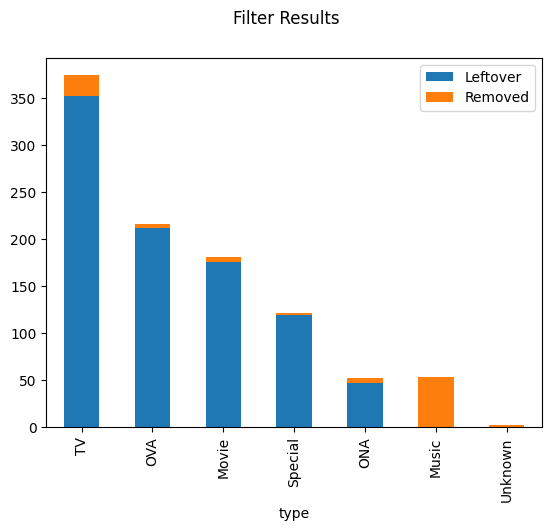

In [66]:
# Stacked barchart counting removed entities
F01,F01_ax = comparison_barchart_by_type(anime_filtered,filtered_out)
F01.suptitle('Filter Results')
# F01.show()

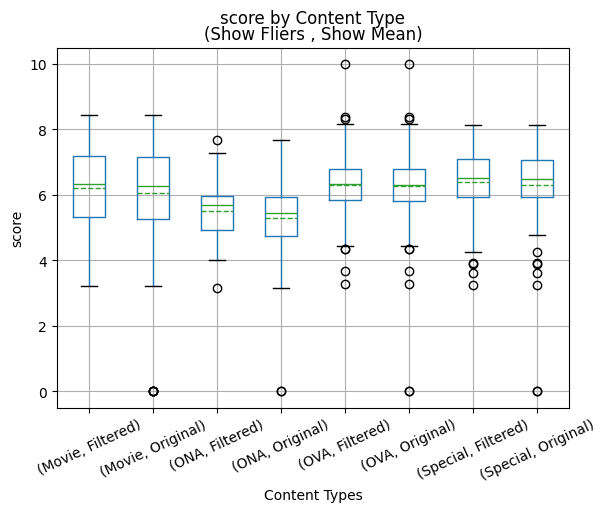

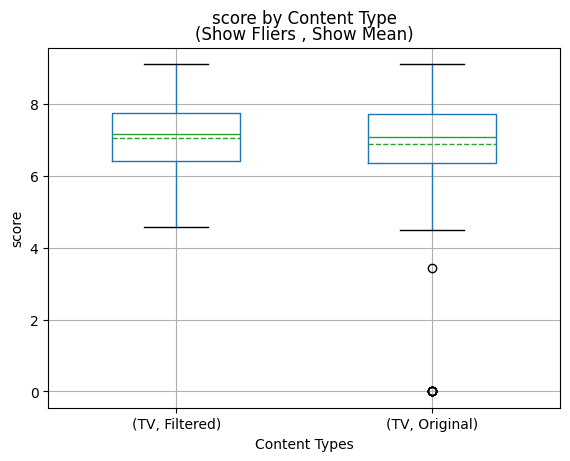

In [67]:
# Compare each type before & after filtering. Score Distributions
F02A, F02A_ax = boxplot_by_type(
	clean_comparison_frame,
	exclude_types=['TV'],
	column='score',
	sub_by='DATASET_DESCRIPTOR',
	rot=25
)
F02B, F02B_ax = boxplot_by_type(
	clean_comparison_frame,
	exclude_types=['Movie','ONA','OVA','Special'],
	column='score',
	sub_by='DATASET_DESCRIPTOR',
)

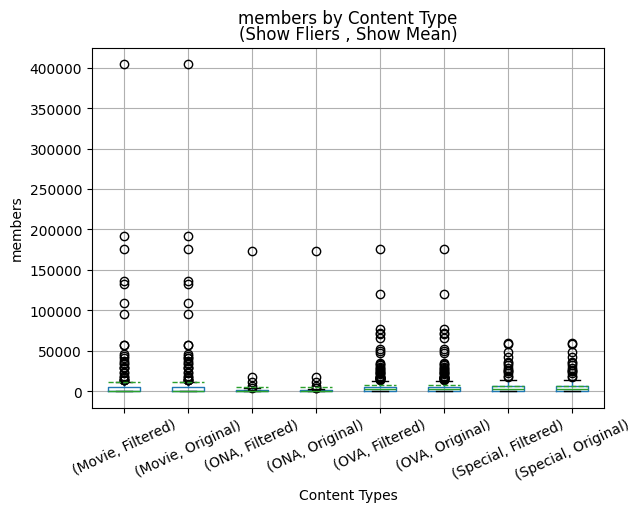

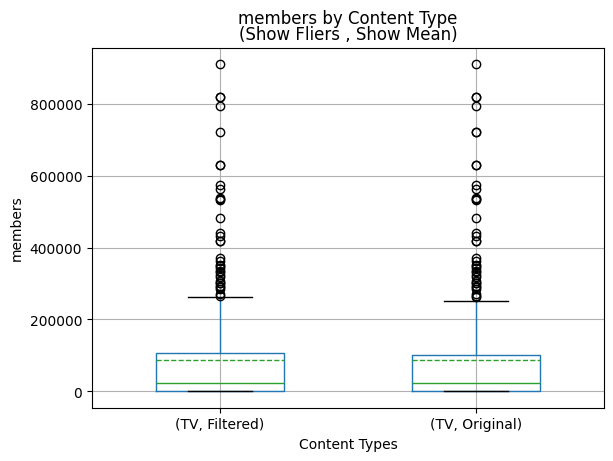

In [68]:
# Compare each type before & after filtering. Score Distributions
F03A, F03A_ax = boxplot_by_type(
	clean_comparison_frame,
	exclude_types=['TV'],
	column='members',
	sub_by='DATASET_DESCRIPTOR',
	rot=25
)
F03B, F03B_ax = boxplot_by_type(
	clean_comparison_frame,
	exclude_types=['Movie','ONA','OVA','Special'],
	column='members',
	sub_by='DATASET_DESCRIPTOR',
)

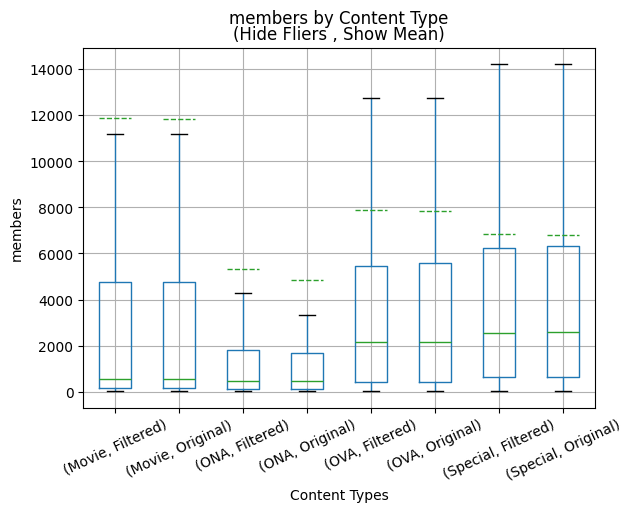

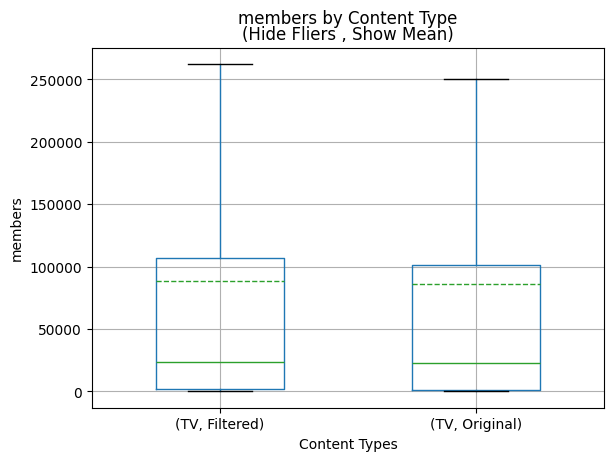

In [69]:
# Compare each type before & after filtering. Score Distributions
F04A, F04A_ax = boxplot_by_type(
	clean_comparison_frame,
	exclude_types=['TV'],
	column='members',
	sub_by='DATASET_DESCRIPTOR',
	show_fliers=False,
	rot=25
)
F04B, F04B_ax = boxplot_by_type(
	clean_comparison_frame,
	exclude_types=['Movie','ONA','OVA','Special'],
	column='members',
	sub_by='DATASET_DESCRIPTOR',
	show_fliers=False,
)

# Data Cleaning

In [70]:
anime_cleaned, cleaned_out = clean_dataset(anime_filtered)
# Comparison Frame
anime_cleaned['DATASET_DESCRIPTOR']='cleaned'
clean_comparison_frame = pd.concat([
	anime_cleaned,
	anime_filtered
],axis=0)

Text(0.5, 0.98, 'Filter Results')

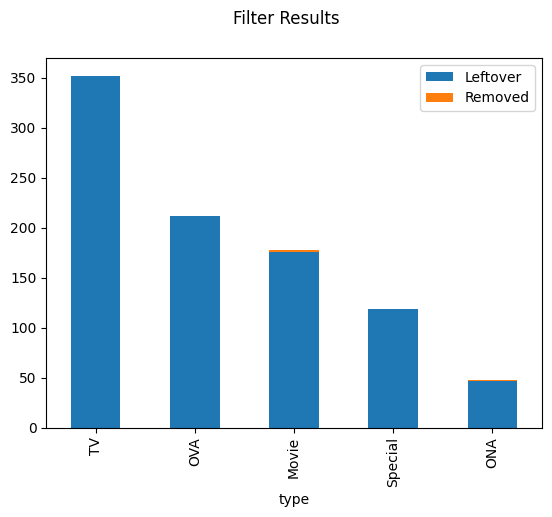

In [71]:
# Stacked barchart counting removed entities
F01,F01_ax = comparison_barchart_by_type(anime_cleaned,cleaned_out)
F01.suptitle('Filter Results')
# F01.show()